### Description: This notebook demonstrates sections 5.2.3 - 5.2.6. This notebook also can be used to reproduce values in Tables 2-4 

### (requires confidenial dataset) --> produced figures 3-4

# Load Libraries

In [2]:
# generic imports
import os
import time
import pickle
from pyprojroot import here
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import sys

# jax import
import jax
import jax.numpy as jnp
from jax import random

# numpyro import
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive

# arviz import
import arviz as az

# local imports
# Add code src directory to sys.path
sys.path.append(str(here() / "src"))
from loader_jkt import load_data
from gp import gp_aggr, gp_aggr_count
from kernels import exp_sq_kernel
from plotting import plot_incidence_map, plot_process

# config
jax.config.update('jax_platform_name', 'cpu');
print(f'We are using {jax.devices()} under the hood.')
print(f'The default path is {here()}')

C:\Users\jessi\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We are using [CpuDevice(id=0)] under the hood.
The default path is c:\Users\jessi\Documents\school\y4\s2\DSE4101\Individual\FYP codes\DSE_FYP


# Data Loading and Prior Generation

In [23]:
# load data
spatial_data = load_data()
print(spatial_data.keys())

dict_keys(['x', 'pol_pts_lo', 'pol_pts_hi', 'df_lo', 'df_hi'])


In [ ]:
# make sure we use only one year of data (change manually)
year_data = 2022
print(f'We are using data for the year {year_data}\n')

# let us filter the data for the years 2023, 2022, 2021, 2020 (must change the input manually for year_data)
df_lo = spatial_data["df_lo"][spatial_data["df_lo"].Year == year_data]
df_hi = spatial_data["df_hi"][spatial_data["df_hi"].Year == year_data]

df_lo = df_lo.copy()
df_hi = df_hi.copy()
df_lo.loc[:, 'incidence'] = df_lo.Cases / df_lo.Population
df_hi.loc[:, 'incidence'] = df_hi.Cases / df_hi.Population


Dengue incidence by province and year (low resolution):
                  incidence
Province    Year           
DKI Jakarta 2020   0.001519
            2021   0.001315
            2022   0.002667
            2023   0.001983 

We are using data for the year 2022



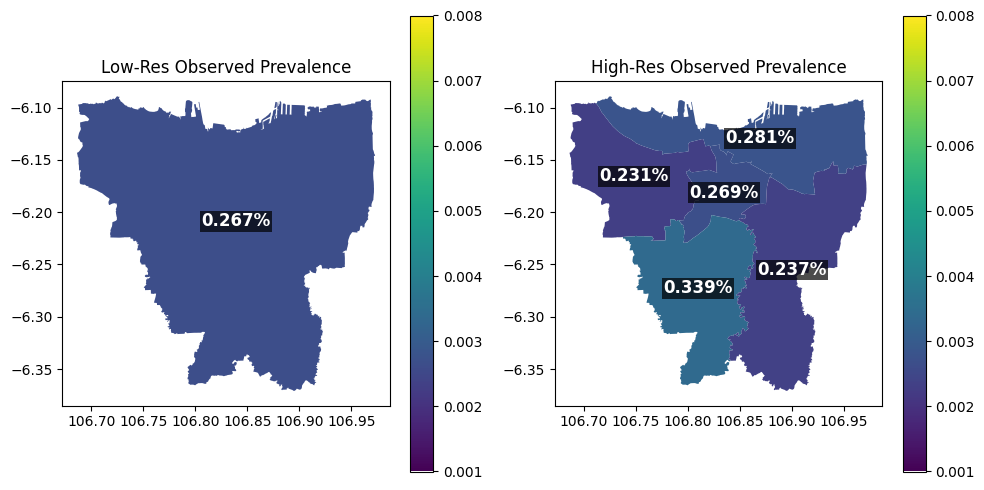

In [ ]:
# Plot data using the reusable function - for low level dengue prevalence
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot low resolution data
plot_incidence_map(df_lo, ax = ax[0], title = "Low-Res Observed Prevalence")

# Plot high resolution data
plot_incidence_map(df_hi, ax = ax[1], title = "High-Res Observed Prevalence")

plt.tight_layout()
plt.show()


In [ ]:
#variable scaling to make sure all the covariate values are in the same scale as that of the raw dengue case counts
total_population = jnp.concatenate([df_lo.Population.values, df_hi.Population.values])
count = jnp.concatenate([df_lo.Cases.values, jnp.full((df_hi.shape[0],), jnp.nan)])
hdi_index = jnp.concatenate([df_lo.HDI.values, df_hi.HDI.values])*100
pop_density = jnp.concatenate([df_lo.Pop_den.values*1e2, (df_hi.Pop_den.values)*1e-1])
urban_frac = jnp.concatenate([df_lo.urbanicity.values, df_hi.urbanicity.values])*100

In [ ]:
# GP parameters with initial kernel length n kernel var choices --> section 5.2.4
# Define the configuration
config = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(4, 1),
    'kernel_var': dist.LogNormal(0, 0.1),
    'total_population': total_population,
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': True
}

# Draw samples from the prior
prior_samples = Predictive(gp_aggr_count, num_samples=1000)(
    random.PRNGKey(6),
    config=config
)

In [8]:
# transform prior samples to arviz inference object
prior_samples_arviz = az.from_numpyro(prior=prior_samples)

### Plot the samples drawn from the GP Prior using initial kernel hyperparameters - Fig 4

In [9]:
# Plot the process
plot_process(prior_samples_arviz.prior.pred_cases.values)

In [10]:
#plot gp_aggr priors directly for the one using config GP hyperparameters
gp_predictive = Predictive(gp_aggr, num_samples = 5)
gp_draws = gp_predictive(random.PRNGKey(6), config)["gp_aggr"]
plot_process(jnp.expand_dims(gp_draws, axis = 0))

### Now plot the samples drawn from the prior using final kernel hyperparameters (Fig 3)

In [27]:
# Define the configuration
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'total_population': total_population,
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': True
}

In [11]:
# Draw samples from the prior
prior_gp_count = Predictive(gp_aggr_count, num_samples=1000)(
    random.PRNGKey(6),
    config=config_count
)
# arviz inference object count model prior
# transform prior samples to arviz inference object
prior_gp_count_arviz = az.from_numpyro(prior=prior_gp_count)

In [12]:
# Plot the process
plot_process(prior_gp_count_arviz.prior.pred_cases.values)

In [28]:
#plot gp_aggr priors directly for the one using config_count GP hyperparameters
gp_draws = gp_predictive(random.PRNGKey(6), config_count)["gp_aggr"]
plot_process(jnp.expand_dims(gp_draws, axis = 0))

NameError: name 'gp_predictive' is not defined

## Run MCMC --> section 5.2.9

In [29]:
# Run MCMC
# Base seed for reproducibility
base_seed = 30  # Keep this fixed for full replicability
# MCMC settings
n_warm = 2000
n_samples = 2000
rng = jax.random.PRNGKey(base_seed)

# Define the model
model = gp_aggr_count

# Define the sampler
sampler = NUTS(model, target_accept_prob=0.95, max_tree_depth=20)
mcmc = MCMC(sampler, # change for later run to target_accept_prob = 0.99 and max_tree_depth = 20
            num_warmup=n_warm,
            num_samples=n_samples,
            num_chains=4,
            chain_method="vectorized",
            progress_bar=True
            )
start = time.time()
mcmc.run(rng, config_count)
end = time.time()
t_elapsed_min = round((end - start) / 60)
print(f"Time taken to run MCMC: {t_elapsed_min} minutes")
# %%

warmup:   1%|▏         | 57/4000 [01:24<1:36:51,  1.47s/it]


KeyboardInterrupt: 

In [ ]:
#save the mcmc from gp for jkt for each specific year (change the year manually)

# Define the path where you want to save the MCMC files
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))  # this assumes you are in the 'src' folder
model_weights_dir = os.path.join(base_dir, 'model weights', 'aggGP')

# Make sure the directory exists, otherwise create it
if not os.path.exists(model_weights_dir):
    os.makedirs(model_weights_dir)

# Define the file path where to save the MCMC object
file_path = os.path.join(model_weights_dir, f"mcmc_jkt_{year_data}_{t_elapsed_min}min_targetprob0.95.pkl")
    

# Save the MCMC object as a pickle file
with open(file_path, 'wb') as f:
        pickle.dump(mcmc, f)

print(f"MCMC object for year {year_data} saved successfully at {file_path}.")

MCMC object for year 2020 saved successfully at c:\Users\jessi\Documents\school\y4\s2\DSE4101\Individual\FYP codes\DSE_FYP\model weights\aggGP\mcmc_jkt_2020_28min_targetprob0.95.pkl.


# MCMC Inference

In [7]:
# Define the model
model = gp_aggr_count

In [32]:
#load the mcmc data u want
with open("../model weights/aggGP/mcmc_jkt_2022_8min_prob0.95.pkl", "rb") as f_1:
    mcmc = pickle.load(f_1)

In [33]:
# creating  prior and posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)
prior = Predictive(model, num_samples=500)(
    rng_key_pr, config_count
)
# transform prior and posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
)

In [34]:
print(mcmc.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "aggr_gp"])


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0    100.12     10.21    100.13     83.53    116.50   1222.95      1.00
          b_hdi      0.02      1.00      0.03     -1.53      1.70    826.60      1.00
  b_pop_density      0.03      0.99      0.03     -1.54      1.76   1158.81      1.00
        b_urban     -0.01      1.00      0.00     -1.68      1.62    456.56      1.02
  kernel_length      0.48      0.29      0.41      0.17      0.80    568.81      1.01
     kernel_var      0.37      0.02      0.37      0.34      0.40   1342.08      1.00
       log_f[0]      2.92      0.66      2.88      1.84      4.00     12.26      1.15
       log_f[1]      2.91      0.65      2.88      1.88      4.03     12.24      1.15
       log_f[2]      2.90      0.66      2.88      1.87      4.00     12.19      1.15
       log_f[3]      2.90      0.66      2.88      1.88      3.97     12.26      1.15
       log_f[4]      2.90      0.65      2.90      1.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases[0],1389.527,967.823,202.085,2644.281,215.843,334.338,16.0,40.0,1.18
pred_cases[1],325.968,218.443,-22.035,629.538,40.600,50.289,30.0,50.0,1.10
pred_cases[2],215.144,153.676,-37.819,476.227,13.655,17.457,208.0,128.0,1.05
pred_cases[3],374.063,247.043,-12.040,744.591,49.999,56.876,24.0,53.0,1.12
pred_cases[4],463.677,296.847,34.291,925.182,63.250,80.407,20.0,48.0,1.15
pred_cases[5],414.112,264.316,3.071,775.125,52.846,71.015,25.0,45.0,1.12
lp[0],1390.295,966.739,223.409,2664.244,215.666,333.828,17.0,40.0,1.18
lp[1],326.203,212.418,0.000,596.356,40.077,51.748,29.0,50.0,1.11
lp[2],215.877,144.277,0.000,432.452,16.134,18.786,120.0,104.0,1.06
lp[3],374.010,240.870,0.000,695.706,49.782,57.963,23.0,53.0,1.13


In [35]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))
r = np.mean(ss['gp_aggr']['n_eff'])
print("Average ESS for all aggGP effects : " + str(round(r)))

ess_lo = np.mean(ss["gp_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["gp_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["gp_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["gp_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggGPE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggGP-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggGP-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggGP-high : {round(r_hat_hi,2)}")

Average ESS for all aggGP effects : 23
Average ESS for all aggGPE-low effects : 21
Max r_hat for all aggGP-low : 1.149999976158142
Average ESS for all aggGP-high effects : 23
Max r_hat for all aggGP-high : 1.159999966621399


In [21]:
#insert the inference into the dataset
mean_pred_cases = numpyro_data.posterior.pred_cases.values.mean(axis=(0, 1))
df_hi['pred_cases_num'] = mean_pred_cases[df_lo.shape[0]:]
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

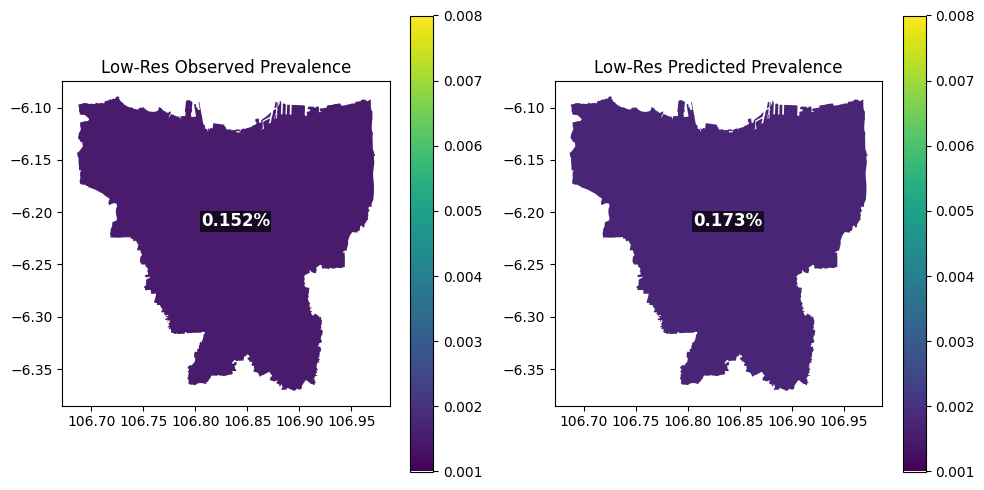

In [22]:
# Plot the process
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_lo, ax = ax[0], title = "Low-Res Observed Prevalence")
plot_incidence_map(df_lo, plot_col = 'pred_cases', ax = ax[1], title = "Low-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

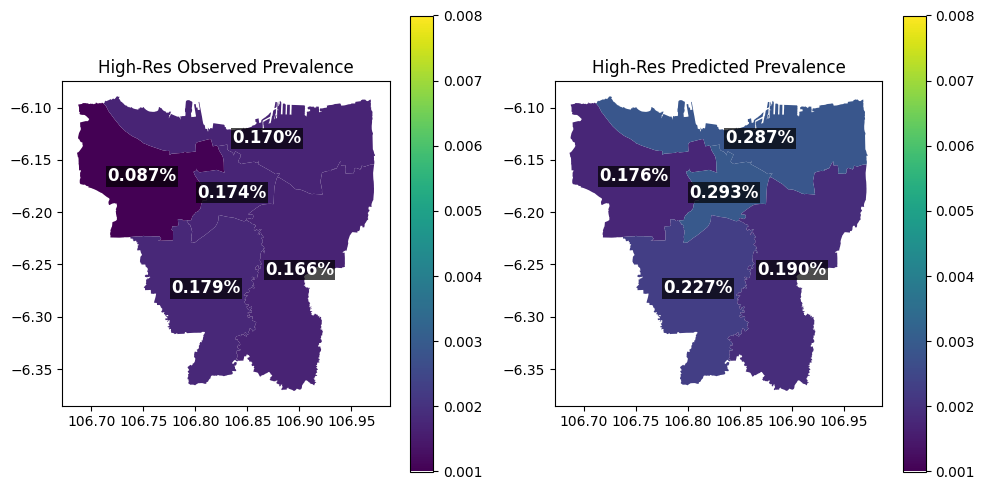

In [23]:
# Plot the process
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plot_incidence_map(df_hi, ax = ax[0], title = "High-Res Observed Prevalence")
plot_incidence_map(df_hi, plot_col = 'pred_cases', ax = ax[1], title = "High-Res Predicted Prevalence")
plt.tight_layout()
plt.show()

In [ ]:
#save the dfs for jkt dist and province dfs with predictions - change the year accordingly (do one by one from 2023 to 2020)
#df_hi.to_csv("../data/processed/df_hi_jkt_w_pred_2022.csv")

In [25]:
n_lo = 1
n_hi = 5

# Find Optimal Target Prob Acceptance! - tested on 2021 data! --> generate table 2 values

In [8]:
# Define the model
model = gp_aggr_count

In [9]:
with open("../model weights/aggGP/mcmc_jkt_2021_30min_targetprob0.9.pkl", "rb") as f_1:
    mcmc_1 = pickle.load(f_1)

with open("../model weights/aggGP/mcmc_jkt_2021_36min_targetprob0.95.pkl", "rb") as f_2:
    mcmc_2 = pickle.load(f_2)

with open("../model weights/aggGP/mcmc_jkt_2021_20min_targetprob0.8.pkl", "rb") as f_3:
    mcmc_3 = pickle.load(f_3)

In [10]:
# load data
spatial_data = load_data()
print(spatial_data.keys())

# Lets lok at the data and dissect it
lo_prev = spatial_data["df_lo"].copy()
lo_prev['incidence'] = (lo_prev.Cases / lo_prev.Population)
print("Dengue incidence by province and year (low resolution):")
print(lo_prev.groupby(['Province', 'Year'])[['incidence']].mean(), '\n')

# make sure we use only one year of data (change manually)
year_data = 2021
print(f'We are using data for the year {year_data}\n')

# let us filter the data for the years 2023, 2022, 2021, 2020 (must change the input manually for year_data)
df_lo = spatial_data["df_lo"][spatial_data["df_lo"].Year == year_data]
df_hi = spatial_data["df_hi"][spatial_data["df_hi"].Year == year_data]

df_lo = df_lo.copy()
df_hi = df_hi.copy()
df_lo.loc[:, 'incidence'] = df_lo.Cases / df_lo.Population
df_hi.loc[:, 'incidence'] = df_hi.Cases / df_hi.Population

total_population = jnp.concatenate([df_lo.Population.values, df_hi.Population.values])
count = jnp.concatenate([df_lo.Cases.values, jnp.full((df_hi.shape[0],), jnp.nan)])
hdi_index = jnp.concatenate([df_lo.HDI.values, df_hi.HDI.values])*100
pop_density = jnp.concatenate([df_lo.Pop_den.values*1e2, (df_hi.Pop_den.values)*1e-1])
urban_frac = jnp.concatenate([df_lo.urbanicity.values, df_hi.urbanicity.values])*100

dict_keys(['x', 'pol_pts_lo', 'pol_pts_hi', 'df_lo', 'df_hi'])
Dengue incidence by province and year (low resolution):
                  incidence
Province    Year           
DKI Jakarta 2020   0.001519
            2021   0.001315
            2022   0.002667
            2023   0.001983 

We are using data for the year 2021



### MCMC 1 prob = 0.9 (best)

In [11]:
# Define the configuration
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'total_population': total_population,
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': True
}

In [12]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_1.get_samples()

posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_1,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
    )

# %%
print(mcmc_1.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "aggr_gp"])


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0     99.97     10.19     99.98     83.26    116.48   1976.06      1.00
          b_hdi     -0.03      1.00     -0.05     -1.71      1.62   1344.53      1.00
  b_pop_density      0.01      1.00      0.00     -1.58      1.67   1755.23      1.00
        b_urban     -0.02      1.02     -0.01     -1.71      1.63   1149.78      1.00
  kernel_length      0.48      0.26      0.42      0.17      0.81    721.77      1.01
     kernel_var      0.37      0.02      0.37      0.34      0.40   1512.52      1.00
       log_f[0]      3.02      0.62      3.06      1.97      4.00     56.82      1.10
       log_f[1]      3.03      0.62      3.04      2.04      4.07     57.28      1.10
       log_f[2]      3.02      0.62      3.04      2.02      4.04     62.21      1.09
       log_f[3]      3.03      0.61      3.03      2.11      4.11     70.60      1.09
       log_f[4]      3.03      0.60      3.03      2.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases[0],1493.302,845.855,249.292,2969.176,125.396,58.622,30.0,266.0,1.10
pred_cases[1],342.481,197.056,-16.604,689.856,18.968,8.177,89.0,397.0,1.04
pred_cases[2],222.625,151.330,-43.800,492.867,7.035,3.533,468.0,1276.0,1.02
pred_cases[3],394.417,227.802,-10.304,787.173,31.207,10.146,50.0,442.0,1.07
pred_cases[4],487.592,271.625,26.545,961.755,37.983,14.987,37.0,383.0,1.08
pred_cases[5],436.706,237.654,19.201,863.769,23.662,12.980,77.0,287.0,1.05
lp[0],1493.107,843.165,270.781,2969.545,125.339,58.621,30.0,263.0,1.10
lp[1],342.326,189.805,0.000,646.978,18.392,8.391,86.0,390.0,1.05
lp[2],222.352,140.765,0.000,451.726,6.906,3.457,427.0,1035.0,1.02
lp[3],393.686,220.402,0.000,747.258,31.054,10.274,47.0,447.0,1.07


In [13]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_1.get_samples(group_by_chain=True))
r = np.mean(ss['gp_aggr']['n_eff'])
print("Average ESS for all aggGP effects : " + str(round(r)))

ess_lo = np.mean(ss["gp_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["gp_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["gp_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["gp_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggGP-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggGP-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggGP-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggGP-high : {round(r_hat_hi,2)}")

Average ESS for all aggGP effects : 98
Average ESS for all aggGP-low effects : 86
Max r_hat for all aggGP-low : 1.0700000524520874
Average ESS for all aggGP-high effects : 100
Max r_hat for all aggGP-high : 1.0800000429153442


In [14]:
#insert the inference into the dataset
mean_pred_cases = numpyro_data.posterior.pred_cases.values.mean(axis=(0, 1))
df_hi['pred_cases_num'] = mean_pred_cases[df_lo.shape[0]:]
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

In [15]:
#save the dfs for jkt dist and province dfs with predictions - change the year accordingly (do one by one from 2023 to 2020)
#df_hi.to_csv("../data/processed/df_hi_jkt_w_pred_2021.csv")

### MCMC 1 prob = 0.95

In [16]:
# Define the configuration
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'total_population': total_population,
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': True
}

In [17]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_2.get_samples()

posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_2,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
    )

# %%
print(mcmc_2.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "aggr_gp"])


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0    100.29     10.21    100.53     84.42    117.67   1306.98      1.00
          b_hdi      0.00      0.99      0.01     -1.55      1.71    947.90      1.00
  b_pop_density     -0.02      1.00     -0.02     -1.66      1.58   1272.70      1.01
        b_urban      0.05      0.98      0.07     -1.62      1.58    667.46      1.01
  kernel_length      0.51      0.30      0.43      0.17      0.87    666.36      1.01
     kernel_var      0.37      0.02      0.37      0.34      0.40   1422.40      1.00
       log_f[0]      3.13      0.56      3.16      2.27      4.07     31.57      1.08
       log_f[1]      3.13      0.56      3.16      2.29      4.07     30.52      1.09
       log_f[2]      3.13      0.56      3.16      2.28      4.06     25.98      1.09
       log_f[3]      3.13      0.55      3.16      2.32      4.08     26.31      1.09
       log_f[4]      3.13      0.56      3.18      2.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases[0],1606.996,747.824,347.972,2918.629,144.559,81.702,27.0,81.0,1.12
pred_cases[1],370.622,186.748,5.804,708.615,28.151,7.510,45.0,178.0,1.07
pred_cases[2],240.195,144.456,-21.849,502.869,12.199,3.642,146.0,546.0,1.04
pred_cases[3],424.293,210.135,53.831,832.735,32.371,10.314,42.0,155.0,1.07
pred_cases[4],527.778,250.708,74.853,976.710,43.790,18.801,32.0,148.0,1.10
pred_cases[5],473.450,223.731,78.877,894.529,40.330,16.445,31.0,134.0,1.10
lp[0],1607.473,747.136,399.101,2966.069,145.403,81.911,26.0,74.0,1.12
lp[1],370.078,178.291,0.000,660.106,27.869,8.052,42.0,162.0,1.07
lp[2],240.757,136.016,0.000,460.095,14.780,3.690,86.0,578.0,1.04
lp[3],424.253,203.090,0.000,740.326,32.718,10.586,38.0,156.0,1.08


In [18]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_2.get_samples(group_by_chain=True))
r = np.mean(ss['gp_aggr']['n_eff'])
print("Average ESS for all aggGP effects : " + str(round(r)))

ess_lo = np.mean(ss["gp_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["gp_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["gp_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["gp_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggGP-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggGP-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggGP-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggGP-high : {round(r_hat_hi,2)}")

Average ESS for all aggGP effects : 33
Average ESS for all aggGP-low effects : 31
Max r_hat for all aggGP-low : 1.1200000047683716
Average ESS for all aggGP-high effects : 34
Max r_hat for all aggGP-high : 1.1200000047683716


### MCMC 1 prob = 0.8

In [19]:
# Define the configuration
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'total_population': total_population,
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': True
}

In [20]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_3.get_samples()

posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_3,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
    )

# %%
print(mcmc_3.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "aggr_gp"])


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0     96.05     10.84     96.80     82.73    113.75      4.95      1.33
          b_hdi     -0.52      1.10     -0.65     -2.57      1.16      8.10      1.40
  b_pop_density     -0.12      0.92     -0.27     -1.44      1.37     10.13      1.17
        b_urban     -0.07      0.81      0.08     -1.39      1.35    205.38      1.02
  kernel_length      0.47      0.26      0.37      0.18      0.74     16.23      1.11
     kernel_var      0.38      0.02      0.38      0.35      0.41     12.44      1.24
       log_f[0]      3.17      0.51      3.07      2.43      4.06      7.08      1.24
       log_f[1]      3.15      0.55      3.07      2.42      4.05      4.91      1.36
       log_f[2]      3.20      0.50      3.08      2.41      4.03      6.67      1.26
       log_f[3]      3.08      0.55      3.10      2.39      3.98      4.17      1.43
       log_f[4]      3.12      0.54      3.10      2.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases[0],1486.167,902.777,494.899,2891.573,376.801,126.621,6.0,9.0,1.90
pred_cases[1],300.384,192.598,51.634,692.819,62.300,16.488,9.0,118.0,1.35
pred_cases[2],174.343,140.658,4.630,474.317,40.351,11.815,14.0,116.0,1.21
pred_cases[3],357.517,215.445,110.319,807.627,75.649,22.361,8.0,64.0,1.42
pred_cases[4],455.075,273.392,146.976,959.510,105.140,27.131,7.0,52.0,1.52
pred_cases[5],399.560,239.467,114.207,843.459,88.803,24.244,7.0,11.0,1.50
lp[0],1485.655,902.034,459.838,2830.171,376.775,127.000,6.0,11.0,1.91
lp[1],301.359,185.584,66.461,674.108,62.248,16.500,9.0,127.0,1.38
lp[2],175.546,134.058,0.000,416.260,40.942,9.869,12.0,130.0,1.24
lp[3],357.213,211.020,106.396,784.001,75.548,22.093,8.0,69.0,1.44


In [21]:
#check ESS and rhat
ss = numpyro.diagnostics.summary(mcmc_3.get_samples(group_by_chain=True))
r = np.mean(ss['gp_aggr']['n_eff'])
print("Average ESS for all aggGP effects : " + str(round(r)))

ess_lo = np.mean(ss["gp_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["gp_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["gp_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["gp_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggGP-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggGP-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggGP-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggGP-high : {round(r_hat_hi,2)}")

Average ESS for all aggGP effects : 3
Average ESS for all aggGP-low effects : 3
Max r_hat for all aggGP-low : 1.8300000429153442
Average ESS for all aggGP-high effects : 3
Max r_hat for all aggGP-high : 1.8300000429153442


# Find Optimal Target Prob Acceptance! - tested on 2020 data!

In [22]:
with open("../model weights/aggGP/mcmc_jkt_2020_21min_targetprob0.9.pkl", "rb") as f_1:
    mcmc_1 = pickle.load(f_1)

with open("../model weights/aggGP/mcmc_jkt_2020_28min_targetprob0.95.pkl", "rb") as f_2:
    mcmc_2 = pickle.load(f_2)

In [23]:
# Define the configuration
config_count = {
    'x': spatial_data["x"],
    'gp_kernel': exp_sq_kernel,
    'noise': 1e-2,
    'jitter': 1e-2,
    'M_lo': jnp.array(spatial_data["pol_pts_lo"]),
    'M_hi': jnp.array(spatial_data["pol_pts_hi"]),
    'kernel_length': dist.InverseGamma(5, 2),
    'kernel_var': dist.LogNormal(-1, 0.05),
    'total_population': total_population,
    'pop_density': pop_density,
    'hdi_index': hdi_index,
    'urban_frac': urban_frac,
    'count': count,
    'prior_pred': True
}

In [24]:
# load data
spatial_data = load_data()
print(spatial_data.keys())

# Lets lok at the data and dissect it
lo_prev = spatial_data["df_lo"].copy()
lo_prev['incidence'] = (lo_prev.Cases / lo_prev.Population)
print("Dengue incidence by province and year (low resolution):")
print(lo_prev.groupby(['Province', 'Year'])[['incidence']].mean(), '\n')

# make sure we use only one year of data (change manually)
year_data = 2020
print(f'We are using data for the year {year_data}\n')

# let us filter the data for the years 2023, 2022, 2021, 2020 (must change the input manually for year_data)
df_lo = spatial_data["df_lo"][spatial_data["df_lo"].Year == year_data]
df_hi = spatial_data["df_hi"][spatial_data["df_hi"].Year == year_data]

df_lo = df_lo.copy()
df_hi = df_hi.copy()
df_lo.loc[:, 'incidence'] = df_lo.Cases / df_lo.Population
df_hi.loc[:, 'incidence'] = df_hi.Cases / df_hi.Population

total_population = jnp.concatenate([df_lo.Population.values, df_hi.Population.values])
count = jnp.concatenate([df_lo.Cases.values, jnp.full((df_hi.shape[0],), jnp.nan)])
hdi_index = jnp.concatenate([df_lo.HDI.values, df_hi.HDI.values])*100
pop_density = jnp.concatenate([df_lo.Pop_den.values*1e2, (df_hi.Pop_den.values)*1e-1])
urban_frac = jnp.concatenate([df_lo.urbanicity.values, df_hi.urbanicity.values])*100

dict_keys(['x', 'pol_pts_lo', 'pol_pts_hi', 'df_lo', 'df_hi'])
Dengue incidence by province and year (low resolution):
                  incidence
Province    Year           
DKI Jakarta 2020   0.001519
            2021   0.001315
            2022   0.002667
            2023   0.001983 

We are using data for the year 2020



### MCMC 1 prob = 0.9, tree depth = 20 --> table 3 values

In [25]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_1.get_samples()

posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_1,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
    )

# %%
print(mcmc_1.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "aggr_gp"])


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0     99.92     10.36    100.15     83.61    116.96    879.51      1.00
          b_hdi     -0.06      0.99     -0.06     -1.70      1.59    541.05      1.01
  b_pop_density      0.01      1.03     -0.01     -1.64      1.66    918.56      1.01
        b_urban     -0.01      0.97      0.02     -1.64      1.54    470.86      1.02
  kernel_length      0.51      0.30      0.43      0.17      0.85    617.60      1.01
     kernel_var      0.37      0.02      0.37      0.34      0.40    928.34      1.00
       log_f[0]      2.95      0.64      2.95      1.92      4.06      5.70      1.28
       log_f[1]      2.94      0.63      2.94      1.90      4.02      5.39      1.30
       log_f[2]      2.94      0.63      2.94      1.83      3.95      5.29      1.31
       log_f[3]      2.94      0.64      2.95      1.92      4.05      5.13      1.32
       log_f[4]      2.94      0.64      2.93      1.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases[0],1386.081,815.116,207.831,2985.267,255.718,89.037,10.0,81.0,1.34
pred_cases[1],324.640,204.942,-36.959,706.395,55.818,13.224,14.0,68.0,1.21
pred_cases[2],214.098,151.321,-38.805,494.813,31.638,5.712,24.0,244.0,1.12
pred_cases[3],366.188,225.936,-27.991,779.215,64.028,17.738,13.0,69.0,1.23
pred_cases[4],453.377,272.409,-27.754,938.519,80.381,24.152,11.0,87.0,1.27
pred_cases[5],412.871,246.937,-20.319,856.014,69.928,20.094,12.0,89.0,1.25
lp[0],1386.700,813.221,199.640,2973.630,255.480,88.932,10.0,82.0,1.35
lp[1],324.349,196.202,0.000,662.367,54.825,13.875,13.0,68.0,1.23
lp[2],213.011,141.678,0.000,447.342,31.803,5.705,20.0,255.0,1.13
lp[3],366.878,219.659,0.000,744.239,64.479,18.438,12.0,66.0,1.25


In [26]:
#check ESS and rhat (high effects)
ss = numpyro.diagnostics.summary(mcmc_1.get_samples(group_by_chain=True))
r = np.mean(ss['gp_aggr']['n_eff'])
print("Average ESS for all aggGP effects : " + str(round(r)))

ess_lo = np.mean(ss["gp_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["gp_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["gp_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["gp_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggGP-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggGP-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggGP-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggGP-high : {round(r_hat_hi,2)}")

Average ESS for all aggGP effects : 5
Average ESS for all aggGP-low effects : 5
Max r_hat for all aggGP-low : 1.309999942779541
Average ESS for all aggGP-high effects : 5
Max r_hat for all aggGP-high : 1.2999999523162842


### MCMC 2 prob = 0.95 (best) --> table 4 values

In [27]:
# creating  posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_2.get_samples()

posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)

# transform posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_2,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
    )

# %%
print(mcmc_2.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "aggr_gp"])


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0    100.07     10.05    100.09     84.29    117.05    889.94      1.01
          b_hdi     -0.01      0.99      0.03     -1.64      1.54    890.12      1.00
  b_pop_density      0.04      1.01      0.04     -1.57      1.70    715.79      1.01
        b_urban      0.01      0.95      0.02     -1.54      1.55   1041.21      1.00
  kernel_length      0.50      0.29      0.42      0.17      0.85    577.36      1.01
     kernel_var      0.37      0.02      0.37      0.34      0.40    923.41      1.00
       log_f[0]      2.99      0.58      2.99      2.03      3.92    107.51      1.03
       log_f[1]      2.99      0.58      2.98      2.02      3.93    105.62      1.03
       log_f[2]      2.99      0.58      2.99      2.09      3.93    102.26      1.03
       log_f[3]      2.99      0.58      2.98      2.00      3.90    106.22      1.04
       log_f[4]      2.98      0.58      2.97      2.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases[0],1413.462,838.980,247.388,2914.723,100.890,68.661,64.0,376.0,1.06
pred_cases[1],331.465,197.656,-11.991,683.168,20.093,10.679,90.0,425.0,1.05
pred_cases[2],219.149,148.080,-39.999,484.057,9.180,4.331,301.0,782.0,1.03
pred_cases[3],379.683,229.191,-6.793,786.373,24.177,14.336,77.0,379.0,1.05
pred_cases[4],468.191,269.260,25.280,940.048,30.436,17.675,65.0,396.0,1.06
pred_cases[5],420.933,237.128,19.289,835.888,26.532,15.405,72.0,421.0,1.06
lp[0],1414.532,836.243,259.501,2899.792,99.807,68.614,65.0,392.0,1.06
lp[1],331.170,190.296,0.000,625.403,20.769,11.050,78.0,377.0,1.05
lp[2],218.579,138.390,0.000,441.375,10.354,4.702,190.0,555.0,1.03
lp[3],379.916,222.076,0.000,729.102,24.502,14.434,72.0,385.0,1.05


In [28]:
#check ESS and rhat (high effects)
ss = numpyro.diagnostics.summary(mcmc_2.get_samples(group_by_chain=True))
r = np.mean(ss['gp_aggr']['n_eff'])
print("Average ESS for all aggGP effects : " + str(round(r)))

ess_lo = np.mean(ss["gp_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["gp_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["gp_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["gp_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggGP-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggGP-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggGP-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggGP-high : {round(r_hat_hi,2)}")

Average ESS for all aggGP effects : 52
Average ESS for all aggGP-low effects : 44
Max r_hat for all aggGP-low : 1.059999942779541
Average ESS for all aggGP-high effects : 54
Max r_hat for all aggGP-high : 1.059999942779541


In [92]:
#insert the inference into the dataset
mean_pred_cases = numpyro_data.posterior.pred_cases.values.mean(axis=(0, 1))
df_hi['pred_cases_num'] = mean_pred_cases[df_lo.shape[0]:]
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

In [ ]:
#save the dfs for jkt dist and province dfs with predictions - change the year accordingly (do one by one from 2023 to 2020)
#df_hi.to_csv("../data/processed/df_hi_jkt_w_pred_2020.csv")

# Find Optimal Target Prob Acceptance! - tested on 2022 data! --> tables 3 & 4 values

In [29]:
#load the mcmc data u want
with open("../model weights/aggGP/mcmc_jkt_2022_30min_targetprob0.9.pkl", "rb") as f_1:
    mcmc_1 = pickle.load(f_1)

with open("../model weights/aggGP/mcmc_jkt_2022_8min_targetprob0.95.pkl", "rb") as f_2:
    mcmc_2 = pickle.load(f_2)

In [30]:
# load data
spatial_data = load_data()
print(spatial_data.keys())

# Lets lok at the data and dissect it
lo_prev = spatial_data["df_lo"].copy()
lo_prev['incidence'] = (lo_prev.Cases / lo_prev.Population)
print("Dengue incidence by province and year (low resolution):")
print(lo_prev.groupby(['Province', 'Year'])[['incidence']].mean(), '\n')

# make sure we use only one year of data (change manually)
year_data = 2022
print(f'We are using data for the year {year_data}\n')

# let us filter the data for the years 2023, 2022, 2021, 2020 (must change the input manually for year_data)
df_lo = spatial_data["df_lo"][spatial_data["df_lo"].Year == year_data]
df_hi = spatial_data["df_hi"][spatial_data["df_hi"].Year == year_data]

df_lo = df_lo.copy()
df_hi = df_hi.copy()
df_lo.loc[:, 'incidence'] = df_lo.Cases / df_lo.Population
df_hi.loc[:, 'incidence'] = df_hi.Cases / df_hi.Population

total_population = jnp.concatenate([df_lo.Population.values, df_hi.Population.values])
count = jnp.concatenate([df_lo.Cases.values, jnp.full((df_hi.shape[0],), jnp.nan)])
hdi_index = jnp.concatenate([df_lo.HDI.values, df_hi.HDI.values])*100
pop_density = jnp.concatenate([df_lo.Pop_den.values*1e2, (df_hi.Pop_den.values)*1e-1])
urban_frac = jnp.concatenate([df_lo.urbanicity.values, df_hi.urbanicity.values])*100

dict_keys(['x', 'pol_pts_lo', 'pol_pts_hi', 'df_lo', 'df_hi'])
Dengue incidence by province and year (low resolution):
                  incidence
Province    Year           
DKI Jakarta 2020   0.001519
            2021   0.001315
            2022   0.002667
            2023   0.001983 

We are using data for the year 2022



### prob 0.9 --> table 3 values

In [31]:
# creating  prior and posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_1.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)
prior = Predictive(model, num_samples=500)(
    rng_key_pr, config_count
)
# transform prior and posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_1,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
)

In [32]:
print(mcmc_1.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "aggr_gp"])


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0     99.37     10.42     99.66     81.47    115.75    611.51      1.01
          b_hdi     -0.06      0.99     -0.05     -1.69      1.62    512.64      1.01
  b_pop_density      0.04      1.00      0.01     -1.54      1.77    884.54      1.01
        b_urban      0.00      0.98     -0.01     -1.54      1.69    415.14      1.03
  kernel_length      0.51      0.31      0.44      0.18      0.82    487.50      1.01
     kernel_var      0.37      0.02      0.37      0.34      0.40    942.78      1.00
       log_f[0]      3.12      0.63      3.19      2.10      4.06      7.64      1.23
       log_f[1]      3.12      0.63      3.18      2.11      4.05      7.72      1.23
       log_f[2]      3.12      0.63      3.18      2.10      4.01      7.32      1.24
       log_f[3]      3.12      0.63      3.19      2.14      4.04      6.85      1.26
       log_f[4]      3.13      0.63      3.18      2.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases[0],1646.596,875.216,365.375,3185.032,306.871,85.655,9.0,120.0,1.37
pred_cases[1],368.961,213.365,-11.617,716.932,65.142,15.826,11.0,175.0,1.28
pred_cases[2],234.845,154.303,-31.739,510.296,35.624,5.730,20.0,268.0,1.16
pred_cases[3],422.398,236.873,-10.304,815.463,74.667,16.149,10.0,150.0,1.31
pred_cases[4],528.612,283.825,45.214,1041.124,96.893,27.116,9.0,151.0,1.37
pred_cases[5],472.321,253.130,52.169,928.174,83.932,22.753,10.0,159.0,1.33
lp[0],1646.142,873.557,363.205,3159.308,306.922,86.535,9.0,122.0,1.37
lp[1],368.010,205.532,0.000,683.969,64.043,16.406,11.0,165.0,1.30
lp[2],234.612,146.278,0.000,473.000,36.148,5.650,17.0,230.0,1.19
lp[3],422.696,231.447,0.000,786.191,74.361,15.825,10.0,155.0,1.33


In [33]:
#check ESS and rhat (high effects)
ss = numpyro.diagnostics.summary(mcmc_1.get_samples(group_by_chain=True))
r = np.mean(ss['gp_aggr']['n_eff'])
print("Average ESS for all aggGP effects : " + str(round(r)))

ess_lo = np.mean(ss["gp_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["gp_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["gp_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["gp_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggGPE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggGP-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggGP-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggGP-high : {round(r_hat_hi,2)}")

Average ESS for all aggGP effects : 5
Average ESS for all aggGPE-low effects : 5
Max r_hat for all aggGP-low : 1.440000057220459
Average ESS for all aggGP-high effects : 5
Max r_hat for all aggGP-high : 1.4199999570846558


### prob 0.95 (best) --> table 4 values

In [34]:
# creating  prior and posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_2.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)
prior = Predictive(model, num_samples=500)(
    rng_key_pr, config_count
)
# transform prior and posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_2,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
)

In [35]:
print(mcmc_2.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "aggr_gp"])


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0    100.12     10.21    100.13     83.53    116.50   1222.95      1.00
          b_hdi      0.02      1.00      0.03     -1.53      1.70    826.60      1.00
  b_pop_density      0.03      0.99      0.03     -1.54      1.76   1158.81      1.00
        b_urban     -0.01      1.00      0.00     -1.68      1.62    456.56      1.02
  kernel_length      0.48      0.29      0.41      0.17      0.80    568.81      1.01
     kernel_var      0.37      0.02      0.37      0.34      0.40   1342.08      1.00
       log_f[0]      2.92      0.66      2.88      1.84      4.00     12.26      1.15
       log_f[1]      2.91      0.65      2.88      1.88      4.03     12.24      1.15
       log_f[2]      2.90      0.66      2.88      1.87      4.00     12.19      1.15
       log_f[3]      2.90      0.66      2.88      1.88      3.97     12.26      1.15
       log_f[4]      2.90      0.65      2.90      1.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases[0],1389.527,967.823,202.085,2644.281,215.843,334.338,16.0,40.0,1.18
pred_cases[1],325.968,218.443,-22.035,629.538,40.600,50.289,30.0,50.0,1.10
pred_cases[2],215.144,153.676,-37.819,476.227,13.655,17.457,208.0,128.0,1.05
pred_cases[3],374.063,247.043,-12.040,744.591,49.999,56.876,24.0,53.0,1.12
pred_cases[4],463.677,296.847,34.291,925.182,63.250,80.407,20.0,48.0,1.15
pred_cases[5],414.112,264.316,3.071,775.125,52.846,71.015,25.0,45.0,1.12
lp[0],1390.295,966.739,223.409,2664.244,215.666,333.828,17.0,40.0,1.18
lp[1],326.203,212.418,0.000,596.356,40.077,51.748,29.0,50.0,1.11
lp[2],215.877,144.277,0.000,432.452,16.134,18.786,120.0,104.0,1.06
lp[3],374.010,240.870,0.000,695.706,49.782,57.963,23.0,53.0,1.13


In [36]:
#check ESS and rhat (high effects)
ss = numpyro.diagnostics.summary(mcmc_2.get_samples(group_by_chain=True))
r = np.mean(ss['gp_aggr']['n_eff'])
print("Average ESS for all aggGP effects : " + str(round(r)))

ess_lo = np.mean(ss["gp_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["gp_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["gp_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["gp_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggGPE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggGP-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggGP-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggGP-high : {round(r_hat_hi,2)}")

Average ESS for all aggGP effects : 23
Average ESS for all aggGPE-low effects : 21
Max r_hat for all aggGP-low : 1.149999976158142
Average ESS for all aggGP-high effects : 23
Max r_hat for all aggGP-high : 1.159999966621399


In [103]:
#insert the inference into the dataset
mean_pred_cases = numpyro_data.posterior.pred_cases.values.mean(axis=(0, 1))
df_hi['pred_cases_num'] = mean_pred_cases[df_lo.shape[0]:]
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

In [ ]:
#save the dfs for jkt dist and province dfs with predictions - change the year accordingly (do one by one from 2023 to 2020)
#df_hi.to_csv("../data/processed/df_hi_jkt_w_pred_2022.csv")

# Save 2023 dataset directly from MCMC with target prob acceptance 0.9 and max tree depth 20

In [37]:
#load the mcmc data u want
with open("../model weights/aggGP/mcmc_jkt_2023_25min_targetprob0.9.pkl", "rb") as f_1:
    mcmc_1 = pickle.load(f_1)

In [38]:
# load data
spatial_data = load_data()
print(spatial_data.keys())

# Lets lok at the data and dissect it
lo_prev = spatial_data["df_lo"].copy()
lo_prev['incidence'] = (lo_prev.Cases / lo_prev.Population)
print("Dengue incidence by province and year (low resolution):")
print(lo_prev.groupby(['Province', 'Year'])[['incidence']].mean(), '\n')

# make sure we use only one year of data (change manually)
year_data = 2023
print(f'We are using data for the year {year_data}\n')

# let us filter the data for the years 2023, 2022, 2021, 2020 (must change the input manually for year_data)
df_lo = spatial_data["df_lo"][spatial_data["df_lo"].Year == year_data]
df_hi = spatial_data["df_hi"][spatial_data["df_hi"].Year == year_data]

df_lo = df_lo.copy()
df_hi = df_hi.copy()
df_lo.loc[:, 'incidence'] = df_lo.Cases / df_lo.Population
df_hi.loc[:, 'incidence'] = df_hi.Cases / df_hi.Population

total_population = jnp.concatenate([df_lo.Population.values, df_hi.Population.values])
count = jnp.concatenate([df_lo.Cases.values, jnp.full((df_hi.shape[0],), jnp.nan)])
hdi_index = jnp.concatenate([df_lo.HDI.values, df_hi.HDI.values])*100
pop_density = jnp.concatenate([df_lo.Pop_den.values*1e2, (df_hi.Pop_den.values)*1e-1])
urban_frac = jnp.concatenate([df_lo.urbanicity.values, df_hi.urbanicity.values])*100

dict_keys(['x', 'pol_pts_lo', 'pol_pts_hi', 'df_lo', 'df_hi'])
Dengue incidence by province and year (low resolution):
                  incidence
Province    Year           
DKI Jakarta 2020   0.001519
            2021   0.001315
            2022   0.002667
            2023   0.001983 

We are using data for the year 2023



### prob 0.9 (table 3 values)

In [39]:
# creating  prior and posterior predictive
rng_key_pr, rng_key_po = random.split(random.PRNGKey(4))
posterior_samples = mcmc_1.get_samples()
posterior_predictive = Predictive(model, posterior_samples)(
    rng_key_po, config_count
)
prior = Predictive(model, num_samples=500)(
    rng_key_pr, config_count
)
# transform prior and posterior predictive to arviz inference objects
Total_districts = df_lo.shape[0] + df_hi.shape[0]
numpyro_data = az.from_numpyro(
    mcmc_1,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords={"district": np.arange(Total_districts)},
    dims={"lp": ["district"]},
)

In [40]:
print(mcmc_1.print_summary())
az.summary(numpyro_data, var_names = ["pred_cases", "lp", "b0", "b_pop_density", "b_hdi", "b_urban", "aggr_gp"])


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0    100.08     10.27    100.30     83.21    116.74   1298.51      1.00
          b_hdi     -0.03      0.97     -0.01     -1.65      1.55    874.05      1.00
  b_pop_density      0.03      0.97      0.04     -1.66      1.50   1448.10      1.01
        b_urban      0.00      0.99     -0.00     -1.55      1.66    560.93      1.01
  kernel_length      0.50      0.26      0.43      0.17      0.84    580.94      1.01
     kernel_var      0.37      0.02      0.37      0.34      0.40   1347.99      1.00
       log_f[0]      3.06      0.59      3.09      2.04      3.95     90.34      1.05
       log_f[1]      3.06      0.59      3.10      2.10      4.01     81.43      1.06
       log_f[2]      3.06      0.59      3.09      2.07      3.95     72.73      1.07
       log_f[3]      3.05      0.59      3.09      2.09      3.98     49.11      1.07
       log_f[4]      3.05      0.58      3.08      2.

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_cases[0],1478.564,717.594,311.450,2817.459,88.440,54.307,54.0,186.0,1.07
pred_cases[1],344.562,187.878,-15.786,681.361,17.263,8.371,119.0,303.0,1.04
pred_cases[2],220.642,145.137,-29.835,489.444,8.183,2.746,320.0,1125.0,1.02
pred_cases[3],392.583,206.482,-15.882,753.983,17.871,9.493,128.0,239.0,1.03
pred_cases[4],482.840,236.327,51.747,935.969,20.570,12.307,116.0,247.0,1.04
pred_cases[5],434.006,210.660,62.909,848.614,21.618,9.948,91.0,329.0,1.04
lp[0],1480.251,716.583,325.920,2808.740,88.882,54.423,53.0,183.0,1.07
lp[1],344.290,179.998,0.000,639.002,16.903,8.698,109.0,269.0,1.04
lp[2],221.999,134.134,0.000,443.280,8.024,2.962,280.0,858.0,1.02
lp[3],392.202,199.494,0.000,718.797,18.113,9.949,121.0,219.0,1.04


In [41]:
#check ESS and rhat (high effects)
ss = numpyro.diagnostics.summary(mcmc_1.get_samples(group_by_chain=True))
r = np.mean(ss['gp_aggr']['n_eff'])
print("Average ESS for all aggGP effects : " + str(round(r)))

ess_lo = np.mean(ss["gp_aggr"]["n_eff"][0:1])
r_hat_lo = np.max(ss["gp_aggr"]["r_hat"][0:1])

ess_hi = np.mean(ss["gp_aggr"]["n_eff"][1:6])
r_hat_hi = np.max(ss["gp_aggr"]["r_hat"][1 : 6])

print(f"Average ESS for all aggGPE-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggGP-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggGP-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggGP-high : {round(r_hat_hi,2)}")

Average ESS for all aggGP effects : 81
Average ESS for all aggGPE-low effects : 81
Max r_hat for all aggGP-low : 1.059999942779541
Average ESS for all aggGP-high effects : 81
Max r_hat for all aggGP-high : 1.0700000524520874


In [119]:
#insert the inference into the dataset
mean_pred_cases = numpyro_data.posterior.pred_cases.values.mean(axis=(0, 1))
df_hi['pred_cases_num'] = mean_pred_cases[df_lo.shape[0]:]
df_lo['pred_cases'] = mean_pred_cases[:df_lo.shape[0]] / df_lo.Population
df_hi['pred_cases'] = mean_pred_cases[df_lo.shape[0]:] / df_hi.Population

In [ ]:
#save the dfs for jkt dist and province dfs with predictions - change the year accordingly (do one by one from 2023 to 2020)
#df_hi.to_csv("../data/processed/df_hi_jkt_w_pred_2023.csv")